In [ ]:
import os
import cv2
import numpy as np

# paths
train_dir = 'Fruits Classification/train'
valid_dir = 'Fruits Classification/valid'
test_dir  = 'Fruits Classification/test'

# Classes
classes = ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']
img_size = (128, 128)

# load images
def load_data(directory):
    X = []
    y = []
    for idx, class_name in enumerate(classes):
        class_path = os.path.join(directory, class_name)
        if not os.path.exists(class_path):
            continue
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize
            X.append(img)
            y.append(idx)
    return np.array(X), np.array(y)

# Load the datasets
X_train, y_train = load_data(train_dir)
X_val, y_val     = load_data(valid_dir)
X_test, y_test   = load_data(test_dir)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print(f"Classes: {classes}")


Training samples: 9700
Validation samples: 200
Testing samples: 100
Classes: ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']


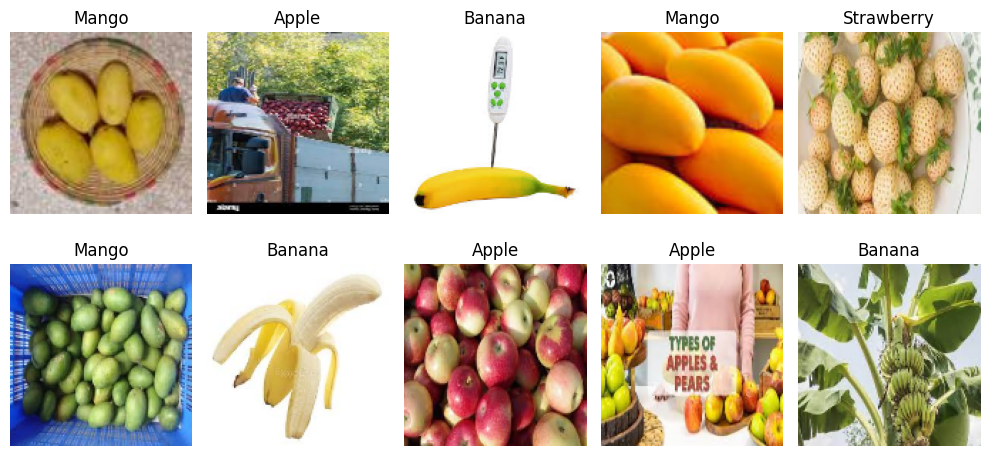

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i in range(10):
    idx = np.random.randint(len(X_train))
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[idx])
    plt.title(classes[y_train[idx]])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [2]:
class_names=classes

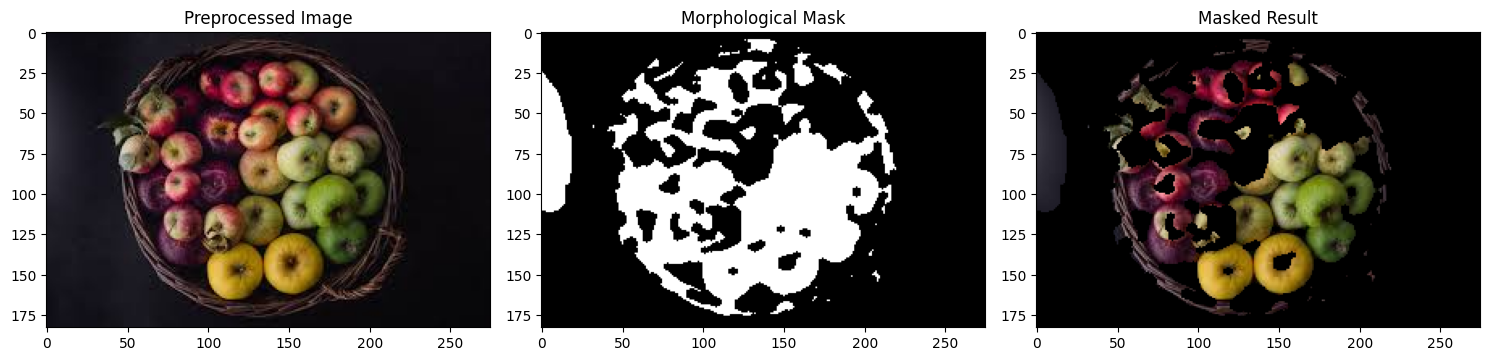

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    blur = cv2.GaussianBlur(img_rgb, (5, 5), 0)
    hsv = cv2.cvtColor(blur, cv2.COLOR_RGB2HSV)
    lower = np.array([20, 40, 40])   # adjust for fruit colors
    upper = np.array([180, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return img_rgb, mask
# Test 
sample_path = os.path.join(train_dir, 'Apple', os.listdir(os.path.join(train_dir, 'Apple'))[80])
img_raw = cv2.imread(sample_path)
preprocessed_img , mask = preprocess_image(img_raw)

# Plot to check
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(preprocessed_img)
plt.title('Preprocessed Image')

plt.subplot(1,3,2)
plt.imshow(mask, cmap='gray')
plt.title('Morphological Mask')

plt.subplot(1,3,3)
masked_img = cv2.bitwise_and(preprocessed_img, preprocessed_img, mask=mask)
plt.imshow(masked_img)
plt.title('Masked Result')

plt.tight_layout()
plt.show()



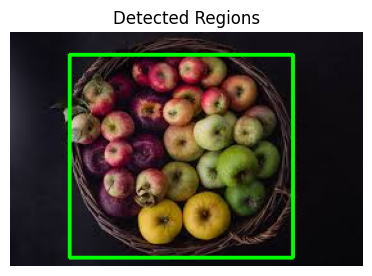

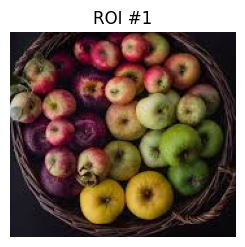

Number of regions detected: 1


In [ ]:
# Segmentation 
def segment_image(img):
    img,  morph_img = preprocess_image(img)

    contours, _ = cv2.findContours(morph_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    segmented_rois = []
    bounding_boxes = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)

        # Filter out small noise
        if w > 60 and h > 60:
            roi = img[y:y+h, x:x+w]
            segmented_rois.append(roi)
            bounding_boxes.append((x, y, w, h))

    return img, segmented_rois, bounding_boxes

# Test 
segmented_img, rois, bboxes = segment_image(img_raw)

# Display
img_copy = segmented_img.copy()
for (x, y, w, h) in bboxes:
    cv2.rectangle(img_copy, (x, y), (x+w, y+h), (0,255,0), 2)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_copy)
plt.title('Detected Regions')
plt.axis('off')
plt.show()

for i, roi in enumerate(rois):
    plt.subplot(1,2,2)
    plt.imshow(roi)
    plt.title(f"ROI #{i+1}")
    plt.axis('off')
    plt.show()
print(f"Number of regions detected: {len(rois)}")




In [ ]:
def load_segmented_data(directory):
    X = []
    y = []
    for idx, class_name in enumerate(classes):
        class_path = os.path.join(directory, class_name)
        if not os.path.exists(class_path):
            continue
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue

            # Apply segmentation 
            try:
                _, rois, _ = segment_image(img)
            except:
                continue

            for roi in rois:
                try:
                    roi_resized = cv2.resize(roi, img_size)
                    roi_resized = roi_resized / 255.0
                    X.append(roi_resized)
                    y.append(idx)
                except:
                    continue
    return np.array(X), np.array(y)
X_train, y_train = load_segmented_data(train_dir)
X_val, y_val     = load_segmented_data(valid_dir)
X_test, y_test   = load_segmented_data(test_dir)

print(f"Training samples after segmentation: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples after segmentation: 10288
Validation samples: 212
Testing samples: 109


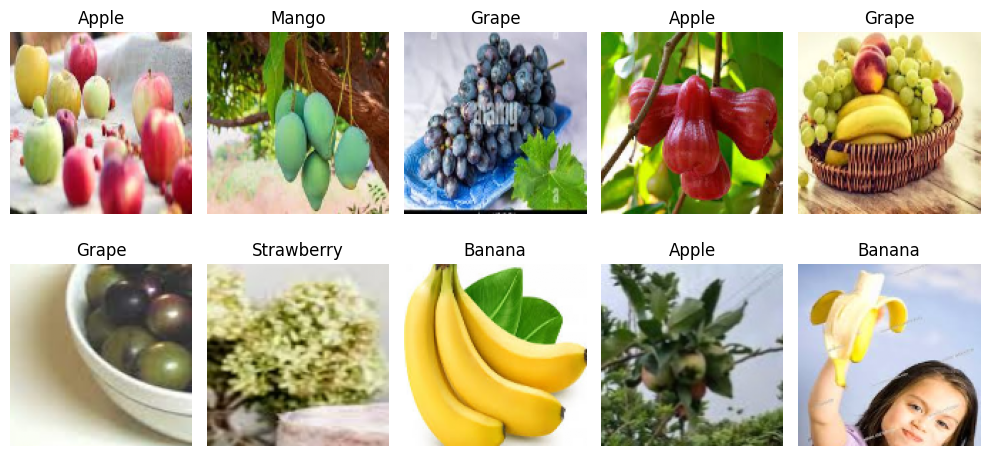

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i in range(10):
    idx = np.random.randint(len(X_train))
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[idx])
    plt.title(classes[y_train[idx]])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

# Apply to data (after load_data function)
X_train_aug = train_datagen.flow(X_train, y_train, batch_size=32)
X_val_aug = val_datagen.flow(X_val, y_val, batch_size=32)

In [ ]:
from tensorflow.keras import layers, models

def create_model(input_shape=(128,128,3), num_classes=5):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


model = create_model()
model.summary()   


c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,285 (12.61 MB)

 Trainable params: 3,305,285 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

history = model.fit(
    X_train_aug,
    validation_data=X_val_aug,
    epochs=55,
    callbacks=[lr_scheduler]
)



c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/55
322/322 ━━━━━━━━━━━━━━━━━━━━ 69s 209ms/step - accuracy: 0.4045 - loss: 1.3819 - val_accuracy: 0.5377 - val_loss: 1.1332 - learning_rate: 0.0010
Epoch 2/55
322/322 ━━━━━━━━━━━━━━━━━━━━ 69s 215ms/step - accuracy: 0.5459 - loss: 1.0962 - val_accuracy: 0.6226 - val_loss: 0.9890 - learning_rate: 0.0010
Epoch 3/55
322/322 ━━━━━━━━━━━━━━━━━━━━ 71s 220ms/step - accuracy: 0.5879 - loss: 1.0103 - val_accuracy: 0.5425 - val_loss: 1.0708 - learning_rate: 0.0010
Epoch 4/55
322/322 ━━━━━━━━━━━━━━━━━━━━ 67s 209ms/step - accuracy: 0.5902 - loss: 1.0215 - val_accuracy: 0.5991 - val_loss: 0.9832 - learning_rate: 0.0010
Epoch 5/55
322/322 ━━━━━━━━━━━━━━━━━━━━ 66s 204ms/step - accuracy: 0.6166 - loss: 0.9746 - val_accuracy: 0.6038 - val_loss: 0.9787 - learning_rate: 0.0010
Epoch 6/55
322/322 ━━━━━━━━━━━━━━━━━━━━ 67s 207ms/step - accuracy: 0.6305 - loss: 0.9194 - val_accuracy: 0.6368 - val_loss: 0.9087 - learning_rate: 0.0010
Epoch 7/55
322/322 ━━━━━━━━━━━━━━━━━━━━ 57s 177ms/step - accuracy: 0.6

In [8]:

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9003 - loss: 0.4453
Test Loss: 0.4219
Test Accuracy: 0.8991


In [25]:
model.save("fruit_classifier2.h5")

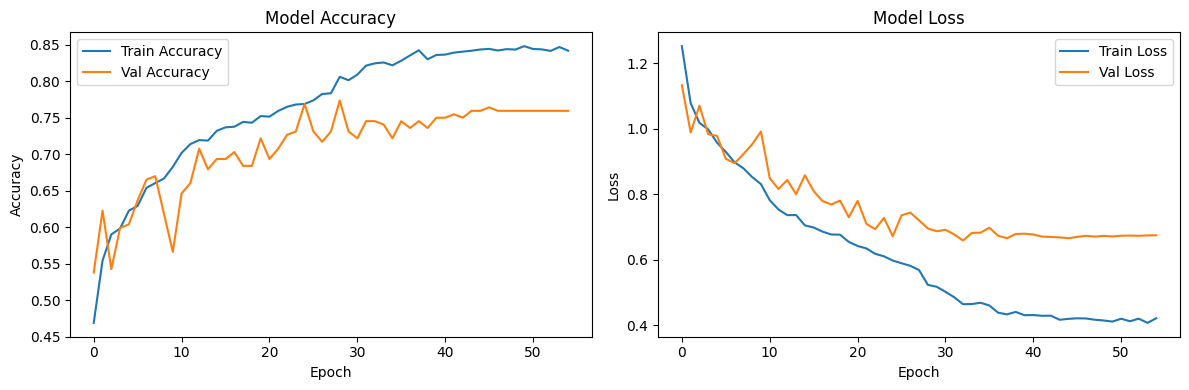

In [ ]:


import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_training_history(history)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np




# Predict 
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Print classification report
print(classification_report(y_test, y_pred, target_names=classes))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
              precision    recall  f1-score   support

       Apple       0.79      0.83      0.81        23
      Banana       0.91      1.00      0.95        21
       Grape       0.95      0.95      0.95        21
       Mango       0.95      0.83      0.88        23
  Strawberry       0.90      0.90      0.90        21

    accuracy                           0.90       109
   macro avg       0.90      0.90      0.90       109
weighted avg       0.90      0.90      0.90       109



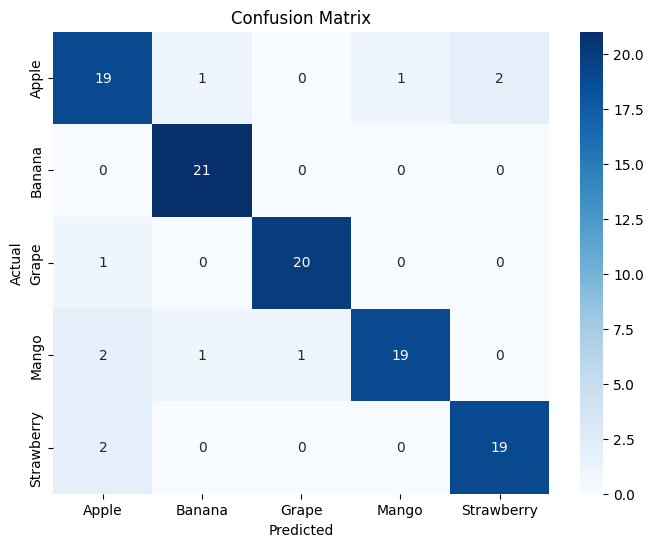

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [1]:
from tensorflow.keras.models import load_model
model = load_model("fruit_classifier2.h5")

In [2]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import cv2
import numpy as np
from skimage.segmentation import active_contour
from skimage.filters import gaussian
from datetime import datetime

class_names = ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']
img_size = (128, 128)
# GrabCut for better segmentation
def grabcut_segment(img):
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (10, 10, img.shape[1]-20, img.shape[0]-20)
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
    segmented = img * mask2[:, :, np.newaxis]
    return segmented

def detect_and_classify(img_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_seg = grabcut_segment(img_rgb)
    output_img = img_rgb.copy()

    gray = cv2.cvtColor(img_seg, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 20, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 30:
            roi = img_rgb[y:y+h, x:x+w]
            roi_resized = cv2.resize(roi, img_size)
            roi_norm = roi_resized / 255.0
            roi_expanded = np.expand_dims(roi_norm, axis=0)

            pred = model.predict(roi_expanded, verbose=0)
            pred_class = class_names[np.argmax(pred)]
            confidence = np.max(pred)

            cv2.rectangle(output_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            label = f"{pred_class} ({confidence * 100:.1f}%)"

            # Put label inside the bounding box
            (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            cv2.rectangle(output_img, (x, y), (x + tw + 4, y + th + 4), (0, 255, 0), -1)
            cv2.putText(output_img, label, (x + 2, y + th + 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    return output_img


def open_file():
    global panel, detected_image_for_saving

    file_path = filedialog.askopenfilename()
    if file_path:
        output_img = detect_and_classify(file_path)
        detected_image_for_saving = output_img.copy()

        # Resize image to fit inside fixed window size
        max_dim = 400
        scale = min(max_dim / output_img.shape[1], max_dim / output_img.shape[0], 1.0)
        new_w, new_h = int(output_img.shape[1] * scale), int(output_img.shape[0] * scale)

        img_resized = cv2.resize(output_img, (new_w, new_h))
        img_pil = Image.fromarray(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
        img_tk = ImageTk.PhotoImage(img_pil)

        # Update the image on the panel
        panel.config(image=img_tk)
        panel.image = img_tk

        # No resizing of the window, keeping it fixed at 800x600
        root.geometry("800x600")
def save_image():
    if detected_image_for_saving is not None:
        save_path = f"image/detected_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
        cv2.imwrite(save_path, detected_image_for_saving)
        print(f"Image saved as {save_path}")

# GUI Window
root = tk.Tk()
root.title("🍎 Fruit Detector")
root.geometry("800x600")  # Initial window size
root.config(bg="#f0f0f0")  # Set a background color for the window

# Frame for buttons
btn_frame = tk.Frame(root, bg="#f0f0f0")
btn_frame.pack(pady=20)

# Open File Button with styling
btn_open = tk.Button(btn_frame, text="Choose an Image", command=open_file, font=("Arial", 14), bg="#4CAF50", fg="white", relief="flat", padx=10, pady=5)
btn_open.pack(side=tk.LEFT, padx=10)

# Save Image Button with styling
btn_save = tk.Button(btn_frame, text="💾 Save Image", command=save_image, font=("Arial", 14), bg="#008CBA", fg="white", relief="flat", padx=10, pady=5)
btn_save.pack(side=tk.LEFT, padx=10)

# Panel for displaying image with rounded corners (simulated)
panel = tk.Label(root, bg="white", relief="solid", bd=1)
panel.pack(padx=20, pady=20)

detected_image_for_saving = None

# Start the GUI
root.mainloop()

Image saved as image/detected_20250504_033214.png
Image saved as image/detected_20250504_033221.png
Image saved as image/detected_20250504_033234.png
Image saved as image/detected_20250504_033258.png
Image saved as image/detected_20250504_033309.png
Image saved as image/detected_20250504_033319.png
Image saved as image/detected_20250504_033823.png
